It seems the current [high scoring script][1] is written in R using H2O. So let us do one in python using XGBoost. 

Thanks to [this script][2] for feature engineering ideas. 

We shall start with importing the necessary modules


  [1]: https://www.kaggle.com/gospursgo/two-sigma-connect-rental-listing-inquiries/h2o-starter-pack/run/835757
  [2]: https://www.kaggle.com/aikinogard/two-sigma-connect-rental-listing-inquiries/random-forest-starter-with-numerical-features

In [1]:
import os
import sys
import operator
import numpy as np
import pandas as pd
from scipy import sparse
#import xgboost as xgb
from sklearn import model_selection, preprocessing, ensemble
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.metrics import log_loss
from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
#from XGBoostPackage import xgbClass
from CrossValidation import CVScore

%matplotlib inline

C:\Users\Student.RM-301-3-PC\AppData\Roaming\Python\Python27\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Student.RM-301-3-PC\AppData\Roaming\Python\Python27\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Now let us write a custom function to run the xgboost model.

Let us read the train and test files and store it.

In [2]:
data_path = "../input/"
train_file = data_path + "train.json"
test_file = data_path + "test.json"
train_df = pd.read_json(train_file)
test_df = pd.read_json(test_file)
print(train_df.shape)
print(test_df.shape)

(49352, 15)
(74659, 14)


We do not need any pre-processing for numerical features and so create a list with those features.

In [4]:
features_to_use  = ["bathrooms", "bedrooms", "latitude", "longitude", "price"]

Now let us create some new features from the given features.

In [5]:
# count of photos #
train_df["num_photos"] = train_df["photos"].apply(len)
test_df["num_photos"] = test_df["photos"].apply(len)

# count of "features" #
train_df["num_features"] = train_df["features"].apply(len)
test_df["num_features"] = test_df["features"].apply(len)

# count of words present in description column #
train_df["num_description_words"] = train_df["description"].apply(lambda x: len(x.split(" ")))
test_df["num_description_words"] = test_df["description"].apply(lambda x: len(x.split(" ")))

# convert the created column to datetime object so as to extract more features 
train_df["created"] = pd.to_datetime(train_df["created"])
test_df["created"] = pd.to_datetime(test_df["created"])

# Let us extract some features like year, month, day, hour from date columns #
train_df["created_year"] = train_df["created"].dt.year
test_df["created_year"] = test_df["created"].dt.year
train_df["created_month"] = train_df["created"].dt.month
test_df["created_month"] = test_df["created"].dt.month
train_df["created_day"] = train_df["created"].dt.day
test_df["created_day"] = test_df["created"].dt.day
train_df["created_hour"] = train_df["created"].dt.hour
test_df["created_hour"] = test_df["created"].dt.hour

# adding all these new features to use list #
features_to_use.extend(["num_photos", "num_features", "num_description_words","created_year", "created_month", "created_day", "listing_id", "created_hour"])

We have 4 categorical features in our data

 - display_address
 - manager_id
 - building_id
 - listing_id

So let us label encode these features.

In [6]:
categorical = ["display_address", "manager_id", "building_id", "street_address"]
for f in categorical:
        if train_df[f].dtype=='object':
            #print(f)
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(train_df[f].values) + list(test_df[f].values))
            train_df[f] = lbl.transform(list(train_df[f].values))
            test_df[f] = lbl.transform(list(test_df[f].values))
            features_to_use.append(f)

We have features column which is a list of string values. So we can first combine all the strings together to get a single string and then apply count vectorizer on top of it.

In [7]:
train_df['features'] = train_df["features"].apply(lambda x: " ".join(["_".join(i.split(" ")) for i in x]))
test_df['features'] = test_df["features"].apply(lambda x: " ".join(["_".join(i.split(" ")) for i in x]))
print(train_df["features"].head())
tfidf = CountVectorizer(stop_words='english', max_features=200)
tr_sparse = tfidf.fit_transform(train_df["features"])
te_sparse = tfidf.transform(test_df["features"])

10                                                         
10000     Doorman Elevator Fitness_Center Cats_Allowed D...
100004    Laundry_In_Building Dishwasher Hardwood_Floors...
100007                               Hardwood_Floors No_Fee
100013                                              Pre-War
Name: features, dtype: object


Now let us stack both the dense and sparse features into a single dataset and also get the target variable.

In [8]:
train_X = sparse.hstack([train_df[features_to_use], tr_sparse]).tocsr()
test_X = sparse.hstack([test_df[features_to_use], te_sparse]).tocsr()

target_num_map = {'high':0, 'medium':1, 'low':2}
train_y = np.array(train_df['interest_level'].apply(lambda x: target_num_map[x]))
print(train_X.shape, test_X.shape)

((49352, 217), (74659, 217))


Now let us do some cross validation to check the scores. 

Please run it in local to get the cv scores. I am commenting it out here for time.

In [17]:
# estimator=RandomForestClassifier()
# param_grid = {'n_estimators':[500, 1000], 'max_features':['auto','sqrt'], 'max_depth':[4]}
# my_scorer=make_scorer(log_loss, greater_is_better=False)
# model = GridSearchCV(
#     estimator=estimator, param_grid=param_grid, n_jobs=-1, cv=5, verbose=20, scoring=my_scorer)
# model.fit(train_X, train_y)


In [10]:
param_grid = {'n_estimators':[500, 600, 700, 800, 900, 1000], 'max_features':['auto','sqrt'], 'max_depth':[4,5,6,7,8,9]}
for n_est in param_grid['n_estimators']:
    for max_feat in param_grid['max_features']:
        for max_d in param_grid['max_depth']:
            model=RandomForestClassifier(n_estimators=n_est, max_features=max_feat, max_depth=max_d)
            score=CVScore(model=model, my_score=log_loss, X_train=train_X, y_train=train_y)
            print('n_est={}, max_feat={}, max_d={}, score={}'.format(n_est, max_feat, max_d, score))

n_est=500, max_feat=auto, max_d=4, score=0.734177433683
n_est=500, max_feat=auto, max_d=5, score=0.722442742144
n_est=500, max_feat=auto, max_d=6, score=0.71138682
n_est=500, max_feat=auto, max_d=7, score=0.700894118829
n_est=500, max_feat=auto, max_d=8, score=0.691463085093
n_est=500, max_feat=auto, max_d=9, score=0.683010332452
n_est=500, max_feat=sqrt, max_d=4, score=0.733710487873
n_est=500, max_feat=sqrt, max_d=5, score=0.721481780477
n_est=500, max_feat=sqrt, max_d=6, score=0.711668884569
n_est=500, max_feat=sqrt, max_d=7, score=0.70140229101
n_est=500, max_feat=sqrt, max_d=8, score=0.691907428753
n_est=500, max_feat=sqrt, max_d=9, score=0.682682357258
n_est=600, max_feat=auto, max_d=4, score=0.733142832136
n_est=600, max_feat=auto, max_d=5, score=0.723107494445
n_est=600, max_feat=auto, max_d=6, score=0.711028627808
n_est=600, max_feat=auto, max_d=7, score=0.70173313679
n_est=600, max_feat=auto, max_d=8, score=0.692280003381
n_est=600, max_feat=auto, max_d=9, score=0.68339723629

Now let us build the final model and get the predictions on the test set.

In [11]:
preds, model = runXGB(train_X, train_y, test_X, num_rounds=400)
out_df = pd.DataFrame(preds)
out_df.columns = ["high", "medium", "low"]
out_df["listing_id"] = test_df.listing_id.values
out_df.to_csv("xgb_starter2.csv", index=False)


Hope this helps the python users as a good starting point.

In [28]:
imp=pd.DataFrame()#(index=features_to_use)
imp['train'] = pd.Series(model.get_score(importance_type='gain'))#, index=features_to_use)
imp = imp.fillna(0)

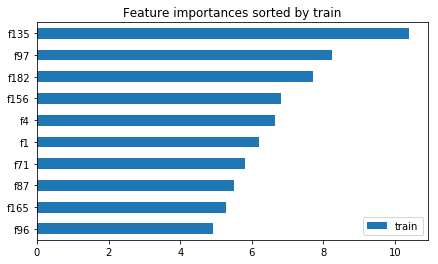

In [30]:
ax=imp.sort_values('train').tail(10).plot.barh(title='Feature importances sorted by train', figsize=(7,4))
